# Merger fractions and modelling for volume limited Galaxy Zoo 1 and Galaxy Zoo 2 sample

In this notebook we use Galaxy Zoo 1 (GZ1) and Galaxy Zoo 2 (GZ2) data which has been matched to group data from Yang, calculating merger fractions for group size, redshift, galaxy velocities and group velocity dispersion. We also use a variety of models to fit the data and calculate their chi-square.

For this notebook we volume limit our sample of galaxies, keeping the original group size of the non-volume limited group.

The GZ1 and GZ2 data can be found at https://data.galaxyzoo.org/
<br>
Information on Data Release 7 (DR7) of the Sloan Digital Sky Survery (SDSS) can be found at https://classic.sdss.org/dr7/
<br>
The Yang group data can be found at https://gax.sjtu.edu.cn/data/Group.html

#### Data
There are 4 different data sets we are using from the GZ data page. For GZ1 we are using "Table 2", which are galaxies from the entire GZ1 data set with spectra available in SDSS DR7 and "Table 3", which are galaxies from the entire GZ1 data set with no spectra available in SDSS DR7. These have 667,944 and 225,268 galaxies in them respectively.
<br>
For GZ1 we are using "Table 5", which are galaxies from the main GZ2 sample spectroscopic redshifts available in SDSS DR7 and "Table 6", which are galaxies from the main GZ2 sample with only photometric redshifts available in SDSS DR7. These have 243,500 and 42,462 galaxies in them respectively.
<br>
We use Yang Catalogue "PetroC" containing 639,359 galaxies and 473,872 groups.

#### Matching GZ1, GZ2 and Yang
The Yang data set covers redshifts $0.01 \leq z \leq 0.2$, whereas GZ1 and GZ2 cover a greater redshift range. Hence we expect to lose some galaxies when we match the GZ1&2 data to the Yang catalogue. We match the GZ1&2 data to the Yang data by right-ascension (ra) and declination (dec) with a maximum error in position of 5 arcsec, preferentially choosing galaxies with spectra available if both a galaxy from the spectroscopic data and from the photometric data match to the same Yang galaxy.

The total number of matches in Yang for each of the 4 galaxy zoo data sets are:

- GZ1 spectroscopic: 586,594 galaxies
- GZ1 photometric: 42,197 galaxies
- GZ2 spectroscopic: 233,767 galaxies
- GZ2 photometric: 19,451 galaxies

In total there are 628,791 galaxies in Yang with GZ1 data and 253,218 galaxies in Yang with GZ2 data, with 629,365 galaxies from Yang having either GZ1 or GZ2 data and 252,644 galaxies with both GZ1 and GZ2 data.

From now on we shall refer to the Yang group data set of 639,359 galaxies as Yang, and the matched GZ1&2 and Yang data sets as GZ1 and GZ2.

### Importing the data
First we import the necessary packages and import the data into an Astropy Table "all_data".

We display the head of the table to get an idea of what the data looks like.

In [1]:
# from astropy.table import Table
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import .fits data as a table
data_filename = "E:\\MPhys Project\\Main Data\\Group_GZ1_GZ2_full_new_best_z_and_Mr_fixed_groups.fits" # All galaxies in group data set with matched GZ1 & Gz2 galaxies

with fits.open(data_filename) as data:
    all_data = Table(data[1].data)

# Display head of data
display(all_data[0:5])

galaxy ID,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,col11 Model,col12 Model,redshift source type,group id,brightest galaxy,most massive galaxy,RA_group,dec_group,z_group,group L_-19.5 log L_odoth2,group stellar mass,halo mass1,halo mass2,mean separation brighter,mean separation massive,f_edge,ID1,ID2,group_size,OBJID_GZ1,RA_GZ1,DEC_GZ1,NVOTE_GZ1,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN,U_GZ1,G_GZ1,R_GZ1,I_GZ1,Z_GZ1,UERR_GZ1,GERR_GZ1,RERR_GZ1,IERR_GZ1,ZERR_GZ1,R50_ARCSEC_GZ1,R90_ARCSEC_GZ1,REDSHIFT_GZ1,REDSHIFTERR_GZ1,REDSHIFTCONF_GZ1,MU_GZ1,MG_GZ1,MR_GZ1,MI_GZ1,MZ_GZ1,MUERR_GZ1,MGERR_GZ1,MRERR_GZ1,MIERR_GZ1,MZERR_GZ1,R50_KPC_GZ1,specobjid_GZ2,dr8objid_GZ2,dr7objid_GZ2,ra_GZ2,dec_GZ2,rastring_GZ2,decstring_GZ2,sample_GZ2,gz2class,total_classifications_GZ2,total_votes_GZ2,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t

### Classifying mergers
Many of the galaxies in our data set have classification data from both GZ1 and GZ2. As GZ1 and GZ2 have different decision trees, we must classify mergers in a different way for each. We can then compare the classifications for galaxies which are in both sets, to see if our classification methods are consistent.

For GZ1 we will use the threshold for merger classification as described in [Darg et al. (2009)](https://arxiv.org/pdf/0903.4937.pdf):
- merger weighted vote fraction $p_m$ > 0.4

Note that this was used in Darg et al. (2009) for only galaxies with redshifts $0.005 < z < 0.1$, but we will use it for galaxies in the range $0.1 \leq z \leq 0.2$ here also.

For GZ2 we will use the threshold for merger classification we have done previously:
- "t06_odd_a14_yes_count" $\geq$ 20
- "t06_odd_a14_yes_debiased" > 0.42
- "t08_odd_feature_a24_merger_count" $\geq$ 10
- "t08_odd_feature_a24_merger_debiased" > 0.4

In [2]:
# Create a new column in the data for GZ1 mergers, with a value of 1 if the galaxy is classified as a merger, and 0 if not
all_data_pandas = all_data.to_pandas()
all_data_pandas["GZ1_merger_yes"] = 0
all_data_pandas.loc[(all_data_pandas["GZ1"] == 1) & (all_data_pandas["P_MG"] > 0.4), "GZ1_merger_yes"] = 1

# Do the same for GZ2 mergers
all_data_pandas["GZ2_merger_yes"] = 0
all_data_pandas.loc[(all_data_pandas["GZ2"] == 1) & (all_data_pandas["t06_odd_a14_yes_count"] >= 20) & (all_data_pandas["t06_odd_a14_yes_debiased"] > 0.42) & (all_data_pandas["t08_odd_feature_a24_merger_count"] >= 10) & (all_data_pandas["t08_odd_feature_a24_merger_debiased"] > 0.4), "GZ2_merger_yes"] = 1

# Return data frame
all_data = Table.from_pandas(all_data_pandas)

# Add column that gives number of merger classifications
all_data["Merger_classifications"] = all_data["GZ1_merger_yes"] + all_data["GZ2_merger_yes"]

### Volume limiting

We use the volume limit we have done in previous notebooks: $M_r < -19$, $0.01 < z_\text{mean} < 0.05$, where $M_r$ is the absolute magnitude and $z_\text{mean}$ is the mean redshift of galaxies in a group with $M_r < -19$.

We import the mean group redshifts and velocity data for galaxies in this volume limit below, then identify which galaxies are in our volume limit.

In [3]:
# Read previously calculated mean z for volume limited groups
volume_limited_mean_z_filename = "E:\\MPhys Project\\Main Data\\mean_redshift_Mr_less_than_19.fits"

with fits.open(volume_limited_mean_z_filename) as data:
    volume_limited_mean_z = Table(data[1].data)

# Crate pandas DataFrames to merge
all_data_pandas = all_data.to_pandas()
volume_limited_mean_z_pandas = volume_limited_mean_z.to_pandas()

# Merge the two DataFrames, keeping all the rows in the full DataFrame
merged = pd.merge(all_data_pandas, volume_limited_mean_z_pandas, on="galaxy ID", how="left")

# Make mean of N=1 groups equal to galaxy redshift
merged.loc[merged["group_size_new"] == 1, "z_group_mean"] = merged.loc[merged["group_size_new"] == 1, "Best_redshift_new"]

# Read previously calculated mean z for volume limited groups
velocities_filename = "E:\\MPhys Project\\Main Data\\velocity_data_volume_limited.fits"

with fits.open(velocities_filename) as data:
    velocity_data_to_merge = Table(data[1].data)

# Crate pandas DataFrames to merge
velocity_data_to_merge_pandas = velocity_data_to_merge.to_pandas()

# Merge the two DataFrames, keeping all the rows in the full DataFrame
velocities_merged = pd.merge(merged, velocity_data_to_merge_pandas, on="galaxy ID", how="left")

# Make copy of data
all_data_pandas = velocities_merged.copy()

# Create column for identifying galaxies in volume limit
all_data_pandas["volume_limited_sample"] = 0

# Set volume_limited_sample == 1 if galaxy is in volume limit
all_data_pandas.loc[(all_data_pandas["Best_Mr_new"] < -19) & (all_data_pandas["z_group_mean"] < 0.05), "volume_limited_sample"] = 1

# Print information about number of galaxies in volume limit
print("Number of galaxies in volume limit: " + str(sum(all_data_pandas["volume_limited_sample"])))
print("Fraction of all galaxies in volume limit: " + str(sum(all_data_pandas["volume_limited_sample"]) / len(all_data_pandas)))
print("Number of mergers in volume limit: " + str(len(all_data_pandas[(all_data_pandas["volume_limited_sample"] == 1) & (all_data_pandas["Merger_classifications"] >= 1)])))

Number of galaxies in volume limit: 67647
Fraction of all galaxies in volume limit: 0.1058044072266129
Number of mergers in volume limit: 2059


### Volume limited groups
Now that we have volume limited our sample, we would like to calculate the number of galaxies that are in the volume limit in each group, or the number of galaxies with $M_r < -19$ in each group. We are only interested in groups for which at least one member has either GZ1 or GZ2 data. If a group does not have any GZ data then we have no morphological information about any of its members and should not be included in the following analysis.

We add a column to our data below containing the number of galaxies in each group that are in the volume limited sample.

In [4]:
# Group by group id and count the number of galaxies in each group in volume limit
volume_limited_galaxies_in_group = all_data_pandas.groupby("group_id_new")["volume_limited_sample"].sum()
volume_limited_galaxies_in_group.rename("volume_limited_galaxies_in_group", inplace=True)

# Merge group size for volume limited groups with main data table
all_data_pandas = pd.merge(all_data_pandas, volume_limited_galaxies_in_group, on="group_id_new", how="left")

# Choose only galaxies in volume limit
volume_limited_groups = all_data_pandas[all_data_pandas["volume_limited_sample"] == 1].copy()

# Add column with value = 0 if the galaxy does not have GZ data, value = 1 if the galaxy does have GZ data
volume_limited_groups["GZ"] = 0
volume_limited_groups.loc[(volume_limited_groups["GZ1"] == 1) | (volume_limited_groups["GZ2"] == 1), "GZ"] = 1

# Count the number of galaxies in each group in the volume limit that have Galaxy Zoo data
volume_limited_groups_GZ_galaxies = volume_limited_groups.groupby("group_id_new")["GZ"].sum()
volume_limited_groups_GZ_galaxies.rename("GZ_galaxies_in_group", inplace=True)
volume_limited_groups_GZ_galaxies

volume_limited_groups = pd.merge(volume_limited_groups, volume_limited_groups_GZ_galaxies, on="group_id_new", how="left")

# Remove any groups from the volume limit which we have no GZ data for
volume_limited_groups = volume_limited_groups[volume_limited_groups["GZ_galaxies_in_group"] > 0].copy()

## Merger fraction and group size
We will now look at how the merger fraction $f_m$ (the fraction of galaxies that are undergoing mergers) changes with group size for our volume limited sample.

Our hypothesis is that at low group sizes the merger fraction will be small, as it is unlikely that, for example, in a group size of 2 that the galaxies are merging. We also expect that for large group sizes the merger fraction will be small, as the energy in larger groups is much higher, meaning the galaxies have greater velocities and therefore will be more likely to fly-by other galaxiess rather than become gravitationally bound and merge, unless it is a head on collision.

For our mergers, we will use the 2,059 galaxies that are classified in either GZ1 or GZ2, and we will calculate the merger fraction against the 44,418 groups in the volume limited sample, which contain 67,478 galaxies (Note that we only have classification data from GZ1 or GZ2 on 67,044 galaxies).

First we create logarithmically spaced bins that have an (approximately) equal number of galaxies in each bin.

To attempt to estimate the error on our merger fraction, we will boostrap the data. For each iteration, we will choose a random sample of our 67,478 galaxies and recalculate the merger fraction using the same bins. This has been done 1000 times, and the minimum and maximum merger fraction at each point will be taken and used to fill between on our plot. A red horizontal line is also added at the value of the merger fraction for $N=1$ groups. This is the "field value", for lone galaxies.

In [5]:
volume_limited_data = volume_limited_groups.copy()

Bins without small groups: [  3   4   6   9  16  30  54 154 324]
Bins with small groups: [  1   2   3   4   6   9  16  30  54 154 324]


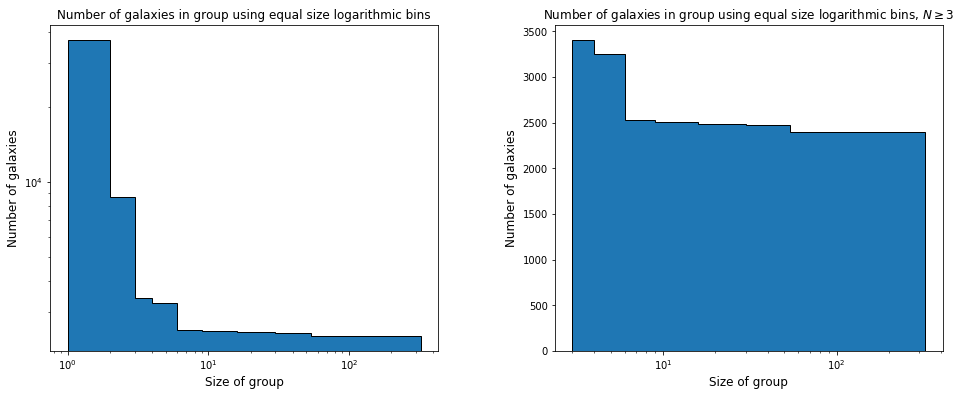

Bootstrapping minimum: [0.01215887 0.06410917 0.06614276 0.05217988 0.0469442  0.03900709
 0.03270609 0.02344454 0.02163904 0.03869464]
Bootstrapping maximum: [0.01364123 0.06939456 0.07534247 0.06204757 0.05616498 0.04772525
 0.04057066 0.02929247 0.02831941 0.04773046]


,Average group size of bin,Merger fraction $f_m$,Galaxies in bin,Groups in bin
0,1.000000,0.012947,37383,37383
1,2.000000,0.066782,8670,4335
2,3.000000,0.071197,3399,1133
3,4.392670,0.058208,3247,748
4,6.844453,0.051717,2533,375
5,11.606715,0.043965,2502,222
6,21.932851,0.036992,2487,117
7,39.965992,0.026721,2470,64
8,90.379858,0.025491,2393,29
9,196.171014,0.043860,2394,12


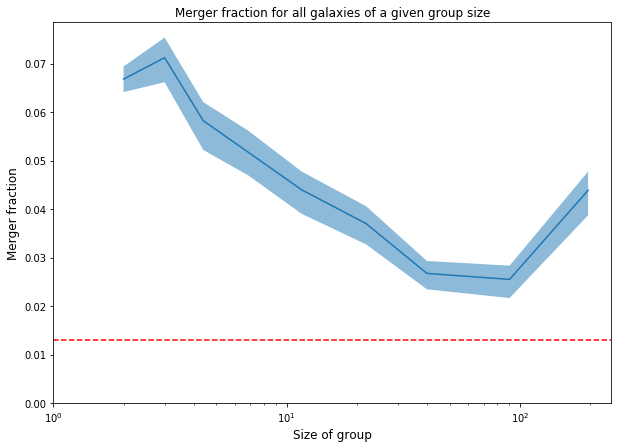

In [33]:
# Create logarithmic bins of equal size without small groups
group_size = volume_limited_data["volume_limited_galaxies_in_group"]
equal_log_bins = pd.qcut(x=np.log10(group_size[group_size > 2]), q=9, labels=False, retbins=True, duplicates="drop")[1]
equal_log_bins = np.power(10, equal_log_bins)
equal_log_bins = np.round(equal_log_bins, 0)

# Add small groups back into new bins
equal_log_bins_with_small = np.insert(equal_log_bins, [0], 1)
equal_log_bins_with_small = np.insert(equal_log_bins_with_small, [1], 2)

# Print the bins that have been calculated
print("Bins without small groups: " + str(equal_log_bins.astype(int)))
print("Bins with small groups: " + str(equal_log_bins_with_small.astype(int)))

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of group size using logarithmic bins
ax[0].hist(group_size, bins=equal_log_bins_with_small, edgecolor="black", histtype="stepfilled")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Size of group", fontsize=12)
ax[0].set_ylabel("Number of galaxies", fontsize=12)
ax[0].set_title("Number of galaxies in group using equal size logarithmic bins", fontsize=12)

# Plot histogram of group size using logarithmic bins for N >= 3
ax[1].hist(group_size, bins=equal_log_bins, edgecolor="black", histtype="stepfilled")
ax[1].set_xscale("log")
# ax[1].set_yscale("log")
ax[1].set_xlabel("Size of group", fontsize=12)
ax[1].set_ylabel("Number of galaxies", fontsize=12)
ax[1].set_title("Number of galaxies in group using equal size logarithmic bins, $N \geq 3$", fontsize=12)

fig.subplots_adjust(wspace=0.3)

plt.show()

def merger_fraction_group_size_bootstrapping(limited_data, group_size_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    limited_data = limited_data[["volume_limited_galaxies_in_group", "Merger_classifications"]]
    
    # Calculate number of points for plotting
    number_of_points = len(group_size_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(limited_data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = limited_data.sample(number_for_boostrapping)
        
        # Bin data by group size, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["volume_limited_galaxies_in_group"], bins=group_size_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["volume_limited_galaxies_in_group"], bins=group_size_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated logarithmic bins
merger_fraction_group_size_bootstrapped = merger_fraction_group_size_bootstrapping(volume_limited_data, equal_log_bins_with_small, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_group_size_bootstrapped_min = np.amin(merger_fraction_group_size_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_group_size_bootstrapped_max = np.amax(merger_fraction_group_size_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping minimum: " + str(merger_fraction_group_size_bootstrapped_min))
print("Bootstrapping maximum: " + str(merger_fraction_group_size_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_group_size_binning(limited_data, group_size_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["volume_limited_galaxies_in_group", "Merger_classifications", "group_id_new"]]
    
    groups_unique = limited_data.drop_duplicates(subset=["group_id_new"], keep="first")
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["volume_limited_galaxies_in_group"], bins=group_size_bins)
    groups_unique_binned, bin_edges = np.histogram(groups_unique["volume_limited_galaxies_in_group"], bins=group_size_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[limited_data["Merger_classifications"] > 0]["volume_limited_galaxies_in_group"], bins=group_size_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["volume_limited_galaxies_in_group"] >= bin_edges[i]) & (limited_data["volume_limited_galaxies_in_group"] < bin_edges[i + 1])]["volume_limited_galaxies_in_group"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int), groups_unique_binned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_groups, group_size_bin_centres, galaxies_in_bin, groups_in_bin = merger_fraction_group_size_binning(volume_limited_data, equal_log_bins_with_small)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_groups_info = list(zip(group_size_bin_centres, merger_fraction_groups, galaxies_in_bin, groups_in_bin))
display(pd.DataFrame(merger_fraction_groups_info, columns=["Average group size of bin", "Merger fraction $f_m$", "Galaxies in bin", "Groups in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(group_size_bin_centres[1:], merger_fraction_groups[1:])
plt.fill_between(group_size_bin_centres[1:], merger_fraction_group_size_bootstrapped_min[1:], merger_fraction_group_size_bootstrapped_max[1:], alpha=0.5)
plt.axhline(y=merger_fraction_groups[0], linestyle="--", c="red")
plt.xscale("log")
plt.xlim(left=1)
plt.ylim(bottom=0)
plt.xlabel("Size of group", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction for all galaxies of a given group size", fontsize=12)
plt.show()

### $f_m$ vs $N$ modelling

Now that we have a curve for the merger fraction against group size, we want to test which kind of models fit the data the best. We do this using SciPy optimise and then calculate the chi-square for the model.

In [34]:
from scipy.optimize import curve_fit

N_values = np.array(group_size_bin_centres[1:])
f_m_values = np.array(merger_fraction_groups[1:])
errors = (merger_fraction_group_size_bootstrapped_max[1:] - merger_fraction_group_size_bootstrapped_min[1:]) / 2

def linear_model(N, a, b):
    f_m = a * N + b
    return f_m

linear_fit_parameters, linear_cov = curve_fit(linear_model, N_values, f_m_values, sigma=errors)
linear_data = linear_model(N_values, linear_fit_parameters[0], linear_fit_parameters[1])
linear_chi_squared = sum(((f_m_values - linear_data) / errors) ** 2) / (len(N_values) - len(linear_fit_parameters))
print("Linear chi square : " + str(linear_chi_squared))

def quadratic_model(N, a, b, c):
    f_m = a * N**2 + b * N + c
    return f_m

quadratic_fit_parameters, quadratic_cov = curve_fit(quadratic_model, N_values, f_m_values, sigma=errors)
quadratic_data = quadratic_model(N_values, quadratic_fit_parameters[0], quadratic_fit_parameters[1], quadratic_fit_parameters[2])
quadratic_chi_squared = sum(((f_m_values - quadratic_data) / errors) ** 2) / (len(N_values) - len(quadratic_fit_parameters))
print("Quadratic chi square : " + str(quadratic_chi_squared))

def cubic_model(N, a, b, c, d):
    f_m = a * N ** 3 + b * N**2 + c * N + d
    return f_m

cubic_fit_parameters, quadratic_cov = curve_fit(cubic_model, N_values, f_m_values, sigma=errors)
cubic_data = cubic_model(N_values, cubic_fit_parameters[0], cubic_fit_parameters[1], cubic_fit_parameters[2], cubic_fit_parameters[3])
cubic_chi_squared = sum(((f_m_values - cubic_data) / errors) ** 2) / (len(N_values) - len(cubic_fit_parameters))
print("Cubic chi square : " + str(cubic_chi_squared))

def quartic_model(N, a, b, c, d, e):
    f_m = a * N ** 4 + b * N**3 + c * N ** 2 + d * N + e
    return f_m

quartic_fit_parameters, quadratic_cov = curve_fit(quartic_model, N_values, f_m_values, sigma=errors)
quartic_data = quartic_model(N_values, quartic_fit_parameters[0], quartic_fit_parameters[1], quartic_fit_parameters[2], quartic_fit_parameters[3], quartic_fit_parameters[4])
quartic_chi_squared = sum(((f_m_values - quartic_data) / errors) ** 2) / (len(N_values) - len(quartic_fit_parameters))
print("Quartic chi square : " + str(quartic_chi_squared))

# def Maxwellian_model(N, a, b, c, d, e):
#     f_m = a * N ** b * np.exp(-c * (N - d)**e)
#     return f_m

# Maxwellian_fit_parameters, Maxwellian_cov = curve_fit(Maxwellian_model, N_values, f_m_values, p0=[0.01, 1, 0.1, 10, 2])

Linear chi square : 20.638220253877886
Quadratic chi square : 5.803347581989215
Cubic chi square : 1.5311605616925814
Quartic chi square : 1.021326298621974


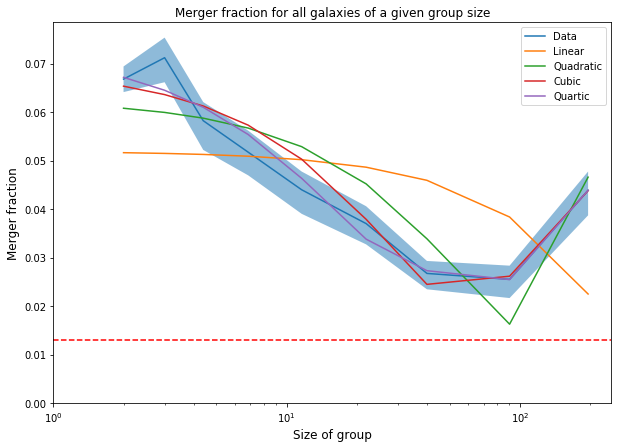

In [35]:
plt.figure(figsize=(10,7))
plt.plot(group_size_bin_centres[1:], merger_fraction_groups[1:], label="Data")
plt.fill_between(group_size_bin_centres[1:], merger_fraction_group_size_bootstrapped_min[1:], merger_fraction_group_size_bootstrapped_max[1:], alpha=0.5)
plt.axhline(y=merger_fraction_groups[0], linestyle="--", c="red")
plt.xscale("log")
plt.xlim(left=1)
plt.ylim(bottom=0)
plt.xlabel("Size of group", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction for all galaxies of a given group size", fontsize=12)

plt.plot(N_values, linear_data, label="Linear")
plt.plot(N_values, quadratic_data, label="Quadratic")
plt.plot(N_values, cubic_data, label="Cubic")
plt.plot(N_values, quartic_data, label="Quartic")
# plt.plot(N_values, Maxwellian_model(N_values, Maxwellian_fit_parameters[0], Maxwellian_fit_parameters[1], Maxwellian_fit_parameters[2]))

plt.legend()

plt.show()

## Merger fraction and redshift

Due to the small range in redshift of our volume limited sample ($ 0.01 < z_\text{mean} < 0.05$), we should not expect the merger fraction to change very much over this range.

Ther merger fraction is generally parameterised as $f_m = f_m(0) (1+z)^m$, where m is the merger index (typically $m$ is in the range $\sim 0 - 4$). Because the redshift $z$ only changes from $z=0.01$ to $z=0.05$, this would not increase the value of $f_m$ from this expression by much. Therefore we should expect our plot of merger fracation against redshift to be fairly constant over our redshift range.

Redshift bins: [0.00988751 0.02766508 0.03357749 0.03862419 0.04314015 0.04657659
 0.05523933]


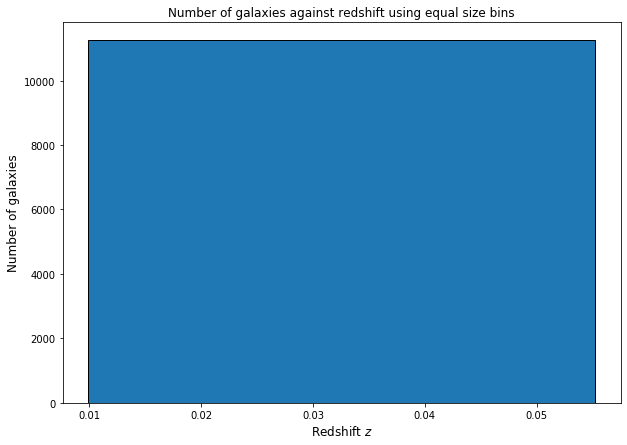

Bootstrapping minimum: [0.03169572 0.03186857 0.02898407 0.02905593 0.02592921 0.02466323]
Bootstrapping maximum: [0.03514661 0.03540085 0.03275131 0.03214321 0.02951079 0.0279125 ]


,Average redshift of bin,Merger fraction $f_m$,Galaxies in bin
0,0.022373,0.033520,11247
1,0.030787,0.033701,11246
2,0.036107,0.030944,11246
3,0.041022,0.030678,11246
4,0.044957,0.028010,11246
5,0.048288,0.026229,11247


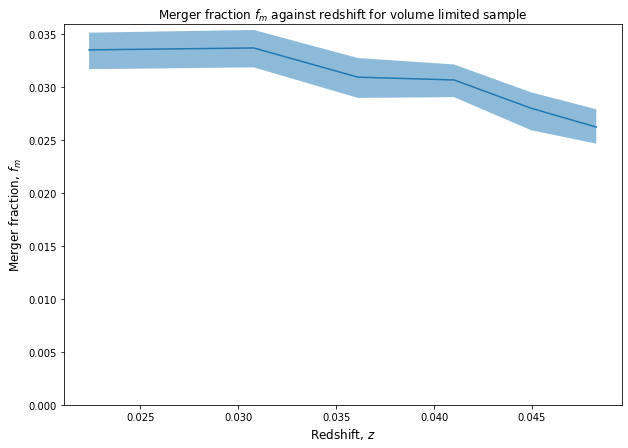

In [9]:
# Create logarithmic bins of equal size without small groups
redshifts = volume_limited_data["Best_redshift_new"]
redshift_equal_bins = pd.qcut(redshifts, q=6, labels=False, retbins=True, duplicates="drop")[1]

# Print the bins that have been calculated
print("Redshift bins: " + str(redshift_equal_bins))

# Plot histogram of redshift using equal bins
plt.figure(figsize=(10,7))
plt.hist(redshifts, bins=redshift_equal_bins, edgecolor="black", histtype="stepfilled")
plt.xlabel("Redshift $z$", fontsize=12)
plt.ylabel("Number of galaxies", fontsize=12)
plt.title("Number of galaxies against redshift using equal size bins", fontsize=12)
plt.show()

def merger_fraction_redshift_bootstrapping(limited_data, redshift_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    limited_data = limited_data[["Best_redshift_new", "Merger_classifications"]]
    
    # Calculate number of points for plotting
    number_of_points = len(redshift_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(limited_data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = limited_data.sample(number_for_boostrapping)
        
        # Bin data by group size, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["Best_redshift_new"], bins=redshift_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["Best_redshift_new"], bins=redshift_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated logarithmic bins
merger_fraction_redshift_bootstrapped = merger_fraction_redshift_bootstrapping(volume_limited_data, redshift_equal_bins, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_redshift_bootstrapped_min = np.amin(merger_fraction_redshift_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_redshift_bootstrapped_max = np.amax(merger_fraction_redshift_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping minimum: " + str(merger_fraction_redshift_bootstrapped_min))
print("Bootstrapping maximum: " + str(merger_fraction_redshift_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_redshift_binning(limited_data, redshift_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["Best_redshift_new", "Merger_classifications"]]
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["Best_redshift_new"], bins=redshift_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[limited_data["Merger_classifications"] > 0]["Best_redshift_new"], bins=redshift_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["Best_redshift_new"] >= bin_edges[i]) & (limited_data["Best_redshift_new"] < bin_edges[i + 1])]["Best_redshift_new"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_redshift = mergersbinned / allbinned
    
    return merger_fraction_redshift, bin_centres, allbinned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_redshift, redshift_bin_centres, galaxies_in_bin = merger_fraction_redshift_binning(volume_limited_data, redshift_equal_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_redshift_info = list(zip(redshift_bin_centres, merger_fraction_redshift, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_redshift_info, columns=["Average redshift of bin", "Merger fraction $f_m$", "Galaxies in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(redshift_bin_centres, merger_fraction_redshift)
plt.fill_between(redshift_bin_centres, merger_fraction_redshift_bootstrapped_min, merger_fraction_redshift_bootstrapped_max, alpha=0.5)
plt.ylim(bottom=0)
plt.xlabel("Redshift, $z$", fontsize=12)
plt.ylabel("Merger fraction, $f_m$", fontsize=12)
plt.title("Merger fraction $f_m$ against redshift for volume limited sample", fontsize=12)
plt.show()

### $f_m$ vs $z$ modelling

In [12]:
from scipy.optimize import curve_fit

z_values = np.array(redshift_bin_centres)
f_m_values = np.array(merger_fraction_redshift)
errors = (merger_fraction_redshift_bootstrapped_max - merger_fraction_redshift_bootstrapped_min) / 2

def linear_model(z, a,  b):
    f_m = a * (1 + z) + b
    return f_m

linear_fit_parameters, linear_cov = curve_fit(linear_model, z_values, f_m_values, sigma=errors)
linear_data = linear_model(z_values, linear_fit_parameters[0], linear_fit_parameters[1])
linear_chi_squared = sum(((f_m_values - linear_data) / errors) ** 2) / (len(z_values) - len(linear_fit_parameters))
print("Linear chi square : " + str(linear_chi_squared))

def power_law_model(z, a, b):
    f_m = a * (1 + z) ** b
    return f_m

power_law_fit_parameters, power_law_cov = curve_fit(power_law_model, z_values, f_m_values, sigma=errors)
power_law_data = power_law_model(z_values, power_law_fit_parameters[0], power_law_fit_parameters[1])
power_law_chi_squared = sum(((f_m_values - power_law_data) / errors) ** 2) / (len(z_values) - len(power_law_fit_parameters))
print("Power law chi square : " + str(power_law_chi_squared))

# def power_law_exponential_model(z, a, b, c):
#     f_m = a * (1 + z) ** b * np.exp(-c * (1 + z))
#     return f_m

# power_law_exponential_fit_parameters, power_law_exponential_cov = curve_fit(power_law_exponential_model, z_values, f_m_values, sigma=errors)
# power_law_exponential_data = power_law_exponential_model(N_values, power_law_exponential_fit_parameters[0], power_law_exponential_fit_parameters[1], power_law_exponential_fit_parameters[2])
# power_law_exponential_chi_squared = sum(((f_m_values - power_law_exponential_data) / errors) ** 2) / (len(z_values) - len(power_law_exponential_fit_parameters))
# print("Power law exponential chi square : " + str(power_law_exponential_chi_squared))

Linear chi square : 0.5645611730629945
Power law chi square : 0.6602886914559527


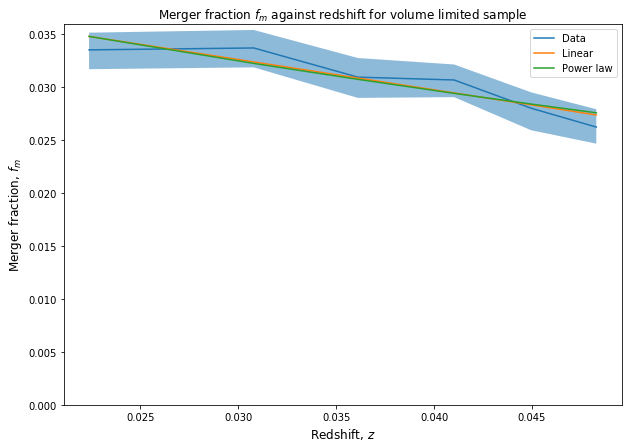

In [15]:
plt.figure(figsize=(10,7))
plt.plot(redshift_bin_centres, merger_fraction_redshift, label="Data")
plt.fill_between(redshift_bin_centres, merger_fraction_redshift_bootstrapped_min, merger_fraction_redshift_bootstrapped_max, alpha=0.5)
plt.ylim(bottom=0)
plt.xlabel("Redshift, $z$", fontsize=12)
plt.ylabel("Merger fraction, $f_m$", fontsize=12)
plt.title("Merger fraction $f_m$ against redshift for volume limited sample", fontsize=12)

plt.plot(z_values, linear_data, label="Linear")
plt.plot(z_values, power_law_data, label="Power law")
# plt.plot(z_values, power_law_exponential_data, label="Cubic")

plt.legend()

plt.show()

## The merger fraction and velocities

#### Calculating velocities
We calculate the proper velocities $v_i$ of a galaxy $i$ within a group as is done in [Danese et al. (1980)](http://articles.adsabs.harvard.edu/pdf/1980A%26A....82..322D):
$$v_i = c \cdot \frac{z_i - z_\text{group}}{1+z_\text{group}}$$
where $z_i$ is the redshift of a galaxy $i$ and $z_\text{group}$ is the mean redshift of all the members of a group. The velocity dispersion of a group can then be calculated using
$$\sigma = \sqrt{\frac{1}{N_\text{group}-1}\sum_{i=1}^{N_\text{group}}(v_i - \left< v_i \right>)^2}$$
We do this for our sample of galaxies below. Note that by using our definition of $v_i$, $\left< v_i \right> = 0$ since $\sum_{i=1}^{N_\text{group}}(z_i - z_\text{group}) = 0$ by definition.

These velocities have already been calculated for our volume limited groups, so we import them below and match them to our volume limited data.

We have previously decided that we are only interested in groups of size $N \geq 3$. This gives us data on 21,425 galaxies within 2,700 groups.

Velocity bins: [   0.           16.24068656   33.98098146   54.66488042   78.93113984
  109.73630843  152.51181547  212.78891047  310.33507458  485.26817798
 2476.61985834]
Velocity dispersion bins: [   0.           52.62773254   84.82194896  118.83386113  155.88227331
  206.53619751  258.48681946  318.18677575  408.0545718   527.04873438
 1542.2534056 ]


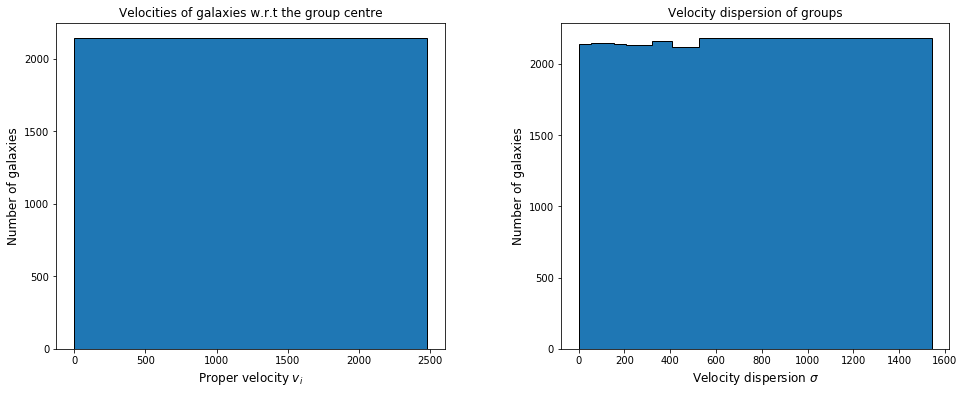

In [16]:
# Create bins of equal size for velocities
velocity_data = volume_limited_data[volume_limited_data["volume_limited_galaxies_in_group"] >= 3].copy()

velocity_equal_bins = pd.qcut(x=velocity_data["v_i_absolute"], q=10, labels=False, retbins=True, duplicates="drop")[1]

velocity_dispersion_equal_bins = pd.qcut(x=velocity_data["velocity_dispersion"], q=10, labels=False, retbins=True, duplicates="drop")[1]

# velocity_equal_log_bins = pd.qcut(x=np.log10(velocity_data["v_i"]), q=10, labels=False, retbins=True, duplicates="drop")[1]
# velocity_equal_log_bins = np.power(10, equal_log_bins)

# velocity_dispersion_log_bins = pd.qcut(x=np.log10(velocity_data["velocity_dispersion"]), q=10, labels=False, retbins=True, duplicates="drop")[1]
# velocity_dispersion_equal_log_bins = np.power(10, equal_log_bins)

# Print the bins that have been calculated
print("Velocity bins: " + str(velocity_equal_bins))
print("Velocity dispersion bins: " + str(velocity_dispersion_equal_bins))

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of velocity using velocity bins
ax[0].hist(velocity_data["v_i_absolute"], bins=velocity_equal_bins, edgecolor="black", histtype="stepfilled")
#ax[0].set_xscale("log")
#ax[0].set_yscale("log")
ax[0].set_xlabel("Proper velocity $v_i$", fontsize=12)
ax[0].set_ylabel("Number of galaxies", fontsize=12)
ax[0].set_title("Velocities of galaxies w.r.t the group centre", fontsize=12)

# Plot histogram of velocity dispersion using velocity dispersion bins
ax[1].hist(velocity_data["velocity_dispersion"], bins=velocity_dispersion_equal_bins, edgecolor="black", histtype="stepfilled")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel("Velocity dispersion $\sigma$", fontsize=12)
ax[1].set_ylabel("Number of galaxies", fontsize=12)
ax[1].set_title("Velocity dispersion of groups", fontsize=12)

fig.subplots_adjust(wspace=0.3)

plt.show()

### Galaxy velocities
We first calculate the merger fraction of the individual galaxy velocities. To attempt to estimate the error on our merger fraction, we will boostrap the data. For each iteration, we will choose a random sample of our 21,425 galaxies with velocity data and recalculate the merger fraction using the same bins. This has been done 1000 times, and the minimum and maximum merger fraction at each point will be taken and used to fill between on our plot.

Bootstrapping velocity minimum: [0.05952381 0.05244029 0.03890041 0.04327666 0.03777545 0.04074265
 0.03952158 0.03112033 0.02368692 0.04261954]
Bootstrapping velocity maximum: [0.07286822 0.0627919  0.04945904 0.05328505 0.04710145 0.04984424
 0.049922   0.03970742 0.03011423 0.0524948 ]


,Average galaxy velocity in bin,Merger fraction $f_m$,Galaxies in bin
0,7.432863,0.066729,2143
1,24.868448,0.058357,2142
2,44.194863,0.045285,2142
3,66.349374,0.048997,2143
4,93.631988,0.043417,2142
5,129.727173,0.045730,2143
6,180.259224,0.045752,2142
7,257.257320,0.035931,2143
8,388.394811,0.027077,2142
9,745.500967,0.047597,2143


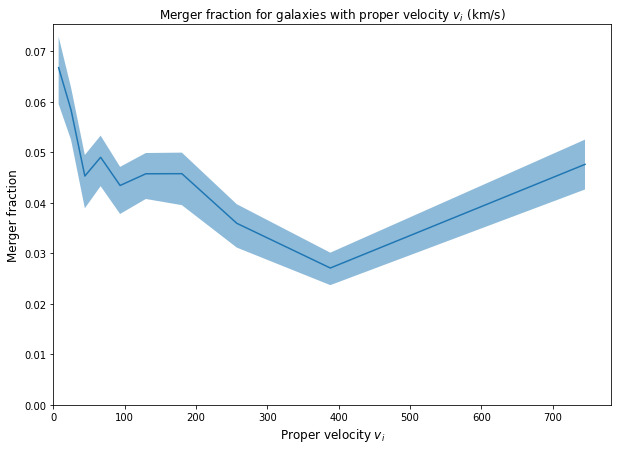

In [17]:
def merger_fraction_velocity_bootstrapping(data, velocity_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    data = data[["v_i_absolute", "Merger_classifications"]].copy()
    
    # Calculate number of points for plotting
    number_of_points = len(velocity_bins) - 1
    
    # Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = data.sample(number_for_boostrapping)
        
        # Bin data by velocities, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["v_i_absolute"], bins=velocity_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["v_i_absolute"], bins=velocity_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated velocity bins
velocity_data_pandas = velocity_data.copy()
merger_fraction_velocity_bootstrapped = merger_fraction_velocity_bootstrapping(velocity_data_pandas, velocity_equal_bins, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_velocity_bootstrapped_min = np.amin(merger_fraction_velocity_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_velocity_bootstrapped_max = np.amax(merger_fraction_velocity_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping velocity minimum: " + str(merger_fraction_velocity_bootstrapped_min))
print("Bootstrapping velocity maximum: " + str(merger_fraction_velocity_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against galaxy velocities
def merger_fraction_velocity_binning(data, velocity_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against galaxy velocities,
    the average velocity of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    data = data[["v_i_absolute", "Merger_classifications"]]
    
    # Bin data by velocity, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["v_i_absolute"], bins=velocity_bins)
    mergersbinned, bin_edges = np.histogram(data[data["Merger_classifications"] > 0]["v_i_absolute"], bins=velocity_bins)
    
    # Calculate the average velocity in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["v_i_absolute"] >= bin_edges[i]) & (data["v_i_absolute"] < bin_edges[i + 1])]["v_i_absolute"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int)

# Call function with all_data and calculated velocity bins
merger_fraction_velocities, velocity_bin_centres, galaxies_in_bin = merger_fraction_velocity_binning(velocity_data_pandas, velocity_equal_bins)

# Create dataframe of average galaxy velocity, merger fraction and gaalxies in each bin and display it
merger_fraction_velocity_info = list(zip(velocity_bin_centres, merger_fraction_velocities, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_velocity_info, columns=["Average galaxy velocity in bin", "Merger fraction $f_m$", "Galaxies in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(velocity_bin_centres, merger_fraction_velocities)
plt.fill_between(velocity_bin_centres, merger_fraction_velocity_bootstrapped_min, merger_fraction_velocity_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("Proper velocity $v_i$", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction for galaxies with proper velocity $v_i$ (km/s)", fontsize=12)
plt.show()

### $f_m$ vs $v_i$ modelling

In [18]:
from scipy.optimize import curve_fit

v_values = np.array(velocity_bin_centres)
f_m_values = np.array(merger_fraction_velocities)
errors = (merger_fraction_velocity_bootstrapped_max - merger_fraction_velocity_bootstrapped_min) / 2

def linear_model(v, a, b):
    f_m = a * v + b
    return f_m

linear_fit_parameters, linear_cov = curve_fit(linear_model, v_values, f_m_values, sigma=errors)
linear_data = linear_model(v_values, linear_fit_parameters[0], linear_fit_parameters[1])
linear_chi_squared = sum(((f_m_values - linear_data) / errors) ** 2) / (len(v_values) - len(linear_fit_parameters))
print("Linear chi square : " + str(linear_chi_squared))

def quadratic_model(v, a, b, c):
    f_m = a * v **2 + b * v + c
    return f_m

quadratic_fit_parameters, quadratic_cov = curve_fit(quadratic_model, v_values, f_m_values, sigma=errors)
quadratic_data = quadratic_model(v_values, quadratic_fit_parameters[0], quadratic_fit_parameters[1], quadratic_fit_parameters[2])
quadratic_chi_squared = sum(((f_m_values - quadratic_data) / errors) ** 2) / (len(v_values) - len(quadratic_fit_parameters))
print("Quadratic chi square : " + str(quadratic_chi_squared))

def cubic_model(v, a, b, c, d):
    f_m = a * v ** 3 + b * v **2 + c * v + d
    return f_m

cubic_fit_parameters, quadratic_cov = curve_fit(cubic_model, v_values, f_m_values, sigma=errors)
cubic_data = cubic_model(v_values, cubic_fit_parameters[0], cubic_fit_parameters[1], cubic_fit_parameters[2], cubic_fit_parameters[3])
cubic_chi_squared = sum(((f_m_values - cubic_data) / errors) ** 2) / (len(v_values) - len(cubic_fit_parameters))
print("Cubic chi square : " + str(cubic_chi_squared))

def quartic_model(v, a, b, c, d, e):
    f_m = a * v ** 4 + b * v **3 + c * v ** 2 + d * v + e
    return f_m

quartic_fit_parameters, quadratic_cov = curve_fit(quartic_model, v_values, f_m_values, sigma=errors)
quartic_data = quartic_model(v_values, quartic_fit_parameters[0], quartic_fit_parameters[1], quartic_fit_parameters[2], quartic_fit_parameters[3], quartic_fit_parameters[4])
quartic_chi_squared = sum(((f_m_values - quartic_data) / errors) ** 2) / (len(v_values) - len(quartic_fit_parameters))
print("Quartic chi square : " + str(quartic_chi_squared))

Linear chi square : 5.090320257476095
Quadratic chi square : 1.0897226716906856
Cubic chi square : 1.2187229801254158
Quartic chi square : 0.8532082224270235


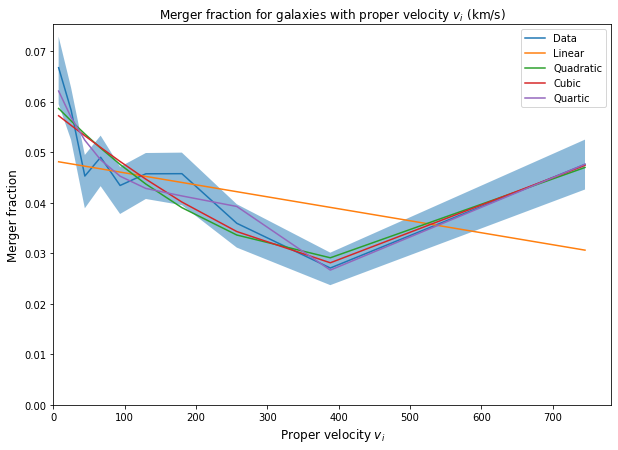

In [19]:
plt.figure(figsize=(10,7))
plt.plot(velocity_bin_centres, merger_fraction_velocities, label="Data")
plt.fill_between(velocity_bin_centres, merger_fraction_velocity_bootstrapped_min, merger_fraction_velocity_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("Proper velocity $v_i$", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction for galaxies with proper velocity $v_i$ (km/s)", fontsize=12)

plt.plot(v_values, linear_data, label="Linear")
plt.plot(v_values, quadratic_data, label="Quadratic")
plt.plot(v_values, cubic_data, label="Cubic")
plt.plot(v_values, quartic_data, label="Quartic")

plt.legend()

plt.show()

### Group velocity dispersion
We now calculate the merger fraction against group velocity dispersion velocities. We again perform a bootstrapping procedure in order to estimate the error on the merger fraction.

Bootstrapping velocity dispersion minimum: [0.07050285 0.05246753 0.04524181 0.04837014 0.05218766 0.03139717
 0.02691511 0.02262211 0.02638522 0.0389479 ]
Bootstrapping velocity dispersion maximum: [0.08179012 0.06233766 0.05506494 0.05742887 0.0633694  0.03920544
 0.034375   0.02918587 0.03306667 0.04840319]


,Average group velocity dispersion in bin,Merger fraction $f_m$,Galaxies in bin,Groups in bin,Average group size in bin
0,30.351563,0.076600,2141,639,3.350548
1,68.466909,0.058357,2142,549,3.901639
2,101.159701,0.050350,2145,478,4.487448
3,136.416268,0.053221,2142,376,5.696809
4,181.185792,0.058466,2138,270,7.918519
5,232.997245,0.035614,2134,178,11.988764
6,282.745118,0.031426,2132,106,20.113208
7,358.744250,0.026413,2158,56,38.535714
8,470.275911,0.029801,2114,28,75.500000
9,609.329520,0.044516,2179,20,108.950000


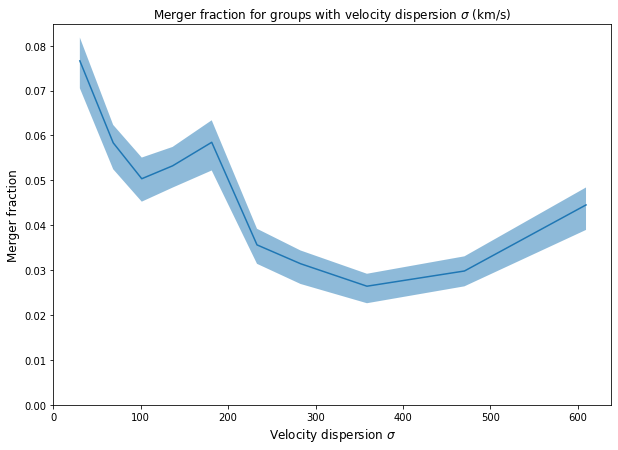

In [23]:
def merger_fraction_velocity_bootstrapping(data, velocity_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    data = data[["velocity_dispersion", "Merger_classifications"]].copy()
    
    # Calculate number of points for plotting
    number_of_points = len(velocity_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = data.sample(number_for_boostrapping)
        
        # Bin data by velocity dispersion, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["velocity_dispersion"], bins=velocity_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["velocity_dispersion"], bins=velocity_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated velocity dispersion bins
merger_fraction_velocity_dispersion_bootstrapped = merger_fraction_velocity_bootstrapping(velocity_data_pandas, velocity_dispersion_equal_bins, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_velocity_dispersion_bootstrapped_min = np.amin(merger_fraction_velocity_dispersion_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_velocity_dispersion_bootstrapped_max = np.amax(merger_fraction_velocity_dispersion_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping velocity dispersion minimum: " + str(merger_fraction_velocity_dispersion_bootstrapped_min))
print("Bootstrapping velocity dispersion maximum: " + str(merger_fraction_velocity_dispersion_bootstrapped_max))

# Define a function that given some data, will return the merger fraction against velocity dispersion
def merger_fraction_velocity_dispersion_binning(data, velocity_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against galaxy velocity dispersion,
    the average velocity dispersion of galaxies in bin for plotting and the number
    of galaxies and groups in each bin."""
    
    # Resample table with only the data needed
    data = data[["velocity_dispersion", "Merger_classifications", "group_id_new"]].copy()
    
    # Create subset with only one representative per group
    groups_unique = data.drop_duplicates(subset=["group_id_new"], keep="first")
    
    # Bin data by velocity dispersion, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["velocity_dispersion"], bins=velocity_bins)
    groups_unique_binned, bin_edges = np.histogram(groups_unique["velocity_dispersion"], bins=velocity_bins)
    groupsbinned, bin_edges = np.histogram(data["velocity_dispersion"], bins=velocity_bins)
    mergersbinned, bin_edges = np.histogram(data[data["Merger_classifications"] > 0]["velocity_dispersion"], bins=velocity_bins)
    
    # Calculate the average velocity dispersion in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["velocity_dispersion"] >= bin_edges[i]) & (data["velocity_dispersion"] < bin_edges[i + 1])]["velocity_dispersion"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int), groups_unique_binned.astype(int)

# Call function with all_data and calculated velocity dispersion bins
merger_fraction_velocity_dispersion, velocity_dispersion_bin_centres, galaxies_in_bin, groups_in_bin = merger_fraction_velocity_dispersion_binning(velocity_data_pandas, velocity_dispersion_equal_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_velocity_dispersion_info = list(zip(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion, galaxies_in_bin, groups_in_bin, galaxies_in_bin / groups_in_bin))
display(pd.DataFrame(merger_fraction_velocity_dispersion_info, columns=["Average group velocity dispersion in bin", "Merger fraction $f_m$", "Galaxies in bin", "Groups in bin", "Average group size in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion)
plt.fill_between(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion_bootstrapped_min, merger_fraction_velocity_dispersion_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("Velocity dispersion $\sigma$", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction for groups with velocity dispersion $\sigma$ (km/s)", fontsize=12)
plt.show()

### $f_m$ vs $\sigma$ modelling

In [21]:
from scipy.optimize import curve_fit

v_values = np.array(velocity_dispersion_bin_centres)
f_m_values = np.array(merger_fraction_velocity_dispersion)
errors = (merger_fraction_velocity_dispersion_bootstrapped_max - merger_fraction_velocity_dispersion_bootstrapped_min) / 2

def linear_model(v, a, b):
    f_m = a * v + b
    return f_m

linear_fit_parameters, linear_cov = curve_fit(linear_model, v_values, f_m_values, sigma=errors)
linear_data = linear_model(v_values, linear_fit_parameters[0], linear_fit_parameters[1])
linear_chi_squared = sum(((f_m_values - linear_data) / errors) ** 2) / (len(v_values) - len(linear_fit_parameters))
print("Linear chi square : " + str(linear_chi_squared))

def quadratic_model(v, a, b, c):
    f_m = a * v **2 + b * v + c
    return f_m

quadratic_fit_parameters, quadratic_cov = curve_fit(quadratic_model, v_values, f_m_values, sigma=errors)
quadratic_data = quadratic_model(v_values, quadratic_fit_parameters[0], quadratic_fit_parameters[1], quadratic_fit_parameters[2])
quadratic_chi_squared = sum(((f_m_values - quadratic_data) / errors) ** 2) / (len(v_values) - len(quadratic_fit_parameters))
print("Quadratic chi square : " + str(quadratic_chi_squared))

def cubic_model(v, a, b, c, d):
    f_m = a * v ** 3 + b * v **2 + c * v + d
    return f_m

cubic_fit_parameters, quadratic_cov = curve_fit(cubic_model, v_values, f_m_values, sigma=errors)
cubic_data = cubic_model(v_values, cubic_fit_parameters[0], cubic_fit_parameters[1], cubic_fit_parameters[2], cubic_fit_parameters[3])
cubic_chi_squared = sum(((f_m_values - cubic_data) / errors) ** 2) / (len(v_values) - len(cubic_fit_parameters))
print("Cubic chi square : " + str(cubic_chi_squared))

def quartic_model(v, a, b, c, d, e):
    f_m = a * v ** 4 + b * v **3 + c * v ** 2 + d * v + e
    return f_m

quartic_fit_parameters, quadratic_cov = curve_fit(quartic_model, v_values, f_m_values, sigma=errors)
quartic_data = quartic_model(v_values, quartic_fit_parameters[0], quartic_fit_parameters[1], quartic_fit_parameters[2], quartic_fit_parameters[3], quartic_fit_parameters[4])
quartic_chi_squared = sum(((f_m_values - quartic_data) / errors) ** 2) / (len(v_values) - len(quartic_fit_parameters))
print("Quartic chi square : " + str(quartic_chi_squared))

Linear chi square : 8.343967747290971
Quadratic chi square : 1.9350215717050505
Cubic chi square : 2.0921177739783006
Quartic chi square : 2.50679539647076


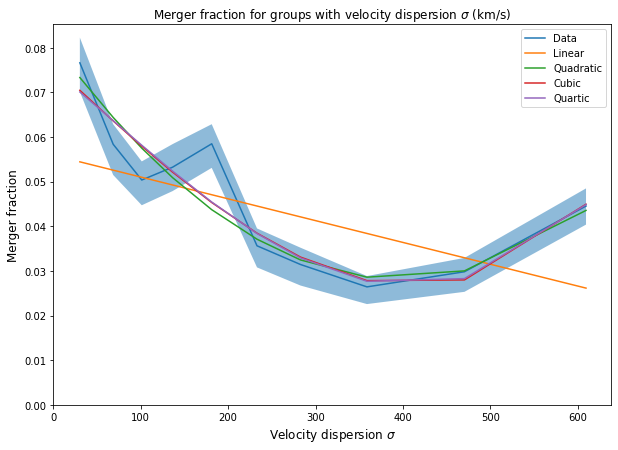

In [22]:
plt.figure(figsize=(10,7))
plt.plot(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion, label="Data")
plt.fill_between(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion_bootstrapped_min, merger_fraction_velocity_dispersion_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("Velocity dispersion $\sigma$", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction for groups with velocity dispersion $\sigma$ (km/s)", fontsize=12)

plt.plot(v_values, linear_data, label="Linear")
plt.plot(v_values, quadratic_data, label="Quadratic")
plt.plot(v_values, cubic_data, label="Cubic")
plt.plot(v_values, quartic_data, label="Quartic")

plt.legend()

plt.show()